In [1]:
from fastlane_bot import Config, ConfigDB, ConfigNetwork, ConfigProvider, Bot
from fastlane_bot.tools.cpc import ConstantProductCurve as CPC, CPCContainer
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CPC))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(Bot))
from fastlane_bot.testing import *
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = [12,6]
from fastlane_bot import __VERSION__
require("2.0", __VERSION__)

ConstantProductCurve v2.6.4.2 (30/Apr/2023)
CarbonBot v2.0-BETA4 (30/Apr/2023)
imported m, np, pd, plt, os, sys, decimal; defined iseq, raises, require
Version = 2.0-BETA4 [requirements >= 2.0 is met]


# Testing the _run functions [NBTest011]

## Mainnet Alchemy Configuration

### Set up the bot

In [2]:
C = Config.new(config=Config.CONFIG_MAINNET)
assert C.DATABASE == C.DATABASE_POSTGRES
assert C.POSTGRES_DB == "mainnet"
assert C.NETWORK == C.NETWORK_MAINNET
assert C.PROVIDER == C.PROVIDER_ALCHEMY
bot = Bot(ConfigObj=C)

In [3]:
help(bot._run)
#help(CPC.from_carbon)
#help(CPC.from_univ3)

Help on method _run in module fastlane_bot.bot:

_run(flashloan_tokens: List[str], CCm: fastlane_bot.tools.cpc.CPCContainer, *, result=None, network: str = 'mainnet') -> Union[Tuple[str, List[Any]], NoneType] method of fastlane_bot.bot.CarbonBot instance
    Working-level entry point for run(), performing the actual execution.
    
    Parameters
    ----------
    flashloan_tokens: List[str]
        The flashloan tokens, ie all tokens that can be borrowed.
    CCm: CPCContainer
        The CPCContainer object containing all market curves.
    result: XS_XXX or None
        What intermediate result to return (default: None)
    
    Returns
    -------
    str
        The transaction hash.



### Set up the curves

In [4]:
cc1 = CPC.from_carbon(pair="ETH/USDC", tkny="ETH", yint=10, y=10, pa=1/2000, pb=1/2010, cid="c-1")
assert iseq(1/2000, cc1.p, cc1.p_max)
assert iseq(1/2010, cc1.p_min)
assert cc1.p_convention() == 'ETH per USDC'
assert cc1.p_min < cc1.p_max
cc1

ConstantProductCurve(k=32240349875.23444, x=8029987.531152765, x_act=0, y_act=10, pair='USDC/ETH', cid='c-1', fee=None, descr=None, constr='carb', params={'y': 10, 'yint': 10, 'A': 5.569293772436992e-05, 'B': 0.022304986837273527, 'pa': 0.0005, 'pb': 0.0004975124378109452})

In [5]:
cu1 = CPC.from_univ3(pair="ETH/USDC", Pmarg=2100.5, uniPa=2100, uniPb=2101, 
                     uniL=m.sqrt(20*2000), fee=0, cid="uni1", descr="")
assert iseq(cu1.p, 2100.5)
assert iseq(cu1.p_min, 2100)
assert iseq(cu1.p_max, 2101)
assert cu1.p_convention() == 'USDC per ETH'
assert cc1.p_min < cc1.p_max
cu1

ConstantProductCurve(k=40000.0, x=4.363838331075834, x_act=0.0005192881949804828, y_act=1.091024513110824, pair='ETH/USDC', cid='uni1', fee=0, descr='', constr='pkpp', params={'L': 200.0})

In [6]:
c0 = CPC.from_pk(pair="ETH/USDC", p=2100, k=0.1*200)

In [7]:
assert cc1.p < cu1.p, f"must have {cc1.p} < {cu1.p} for arbitrage"

pair = ETH/USDC


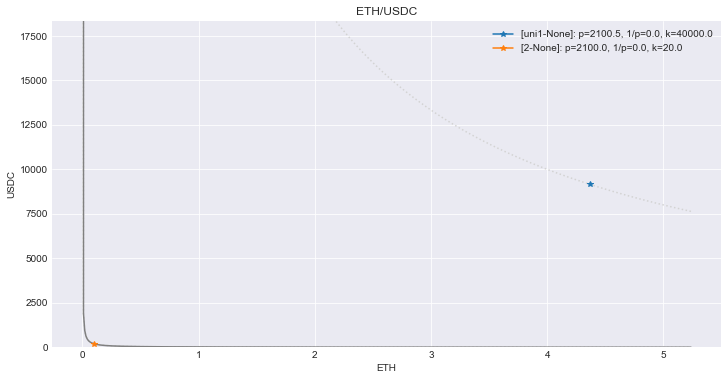

pair = USDC/ETH


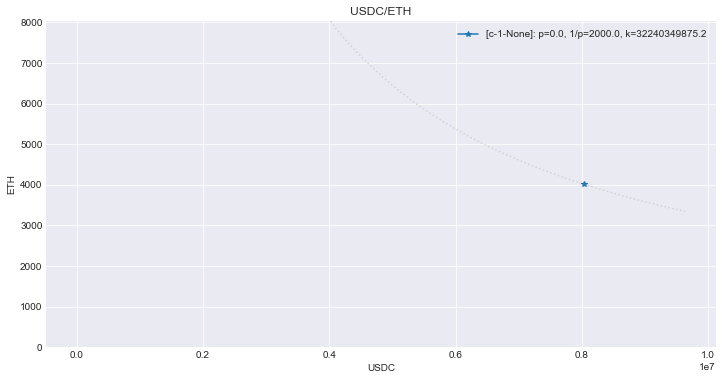

In [8]:
CCm = CPCContainer([cc1, cu1, c0])
CCm.plot()

### Run `_find_arbitrage_opportunities}`

#### AO_TOKENS

In [9]:
r=bot._find_arbitrage_opportunities(flashloan_tokens=["ETH"], CCm=CCm, result=bot.AO_TOKENS)
r

({'ETH', 'USDC'}, [('USDC', 'ETH')])

In [10]:
assert r[0] == {'ETH', 'USDC'}
assert r[1] == [('USDC', 'ETH')]

#### AO_CANDIDATES

In [11]:
bot._find_arbitrage_opportunities(flashloan_tokens=["ETH"], CCm=CCm, result=bot.AO_CANDIDATES)

[margp_optimizer] singular Jacobian, using lstsq instead


2023-04-30 20:52:26,043 [fastlane:ERROR] - [TODO CLEAN UP]{e}


AttributeError: 'CarbonBot' object has no attribute '_check_if_not_carbon'

#### Full

In [ ]:
bot._find_arbitrage_opportunities(flashloan_tokens=["ETH"], CCm=CCm)

### Run `_run`

#### XS_ARBOPPS

In [ ]:
bot._run(flashloan_tokens=["ETH"], CCm=CCm, result=bot.XS_ARBOPPS)

#### XS_TI

In [ ]:
bot._run(flashloan_tokens=["ETH"], CCm=CCm, result=bot.XS_TI)

#### XS_ORDSCAL

In [ ]:
bot._run(flashloan_tokens=["ETH"], CCm=CCm, result=bot.XS_ORDSCAL)

#### XS_AGGTI

In [ ]:
bot._run(flashloan_tokens=["ETH"], CCm=CCm, result=bot.XS_AGGTI)

#### XS_ORDTI

In [ ]:
bot._run(flashloan_tokens=["ETH"], CCm=CCm, result=bot.XS_ORDTI)

#### XS_ENCTI

In [ ]:
bot._run(flashloan_tokens=["ETH"], CCm=CCm, result=bot.XS_ENCTI)

#### XS_ROUTE

In [ ]:
bot._run(flashloan_tokens=["ETH"], CCm=CCm, result=bot.XS_ROUTE)